# Climate 323 Final Project

In [77]:
# Importing necessary libraries
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt



varnames = ['Date', 'Bz', 'Pressure', 'Sunspots', 'DST'] #setting own varnames 

In [78]:
#Reading in data
def tconvert(x):
    # Extract year, month, day, hour from the datetime string
    #REFERENCEE
    year = int(x[:4])
    month = int(x[5:7])
    day = int(x[8:10])
    hour = int(x[11:13])
    # Create a datetime object with the extracted values
    return dt.datetime(year, month, day, hour)

#reading in data using genfromtxt and skipping unecessary rows
data = np.genfromtxt('OMNI2_H0_MRG1HR_2258698.csv', delimiter=',', names = varnames, converters={0: tconvert}, 
                          encoding='utf-8', skip_header=103, dtype = None)

print(data[0])


(datetime.datetime(1986, 1, 1, 0, 0), 999.9, 99.99, 0, -25)


In [79]:
# Replace zero values in 'Pressure' with a small non-zero value so that we don't divide by 0 (these will be masked later)
data['Pressure'] = np.where(data['Pressure'] == 0, 0.00001, data['Pressure'])

#Shue et al. formula
magpause_dist = (10.22 + 1.29 * np.tanh(0.184 * (data['Bz'] + 8.14))) * (1. / data['Pressure']) ** (1. / 6.6)

#masked array where magnetopause standoff distance is masked for invalid Bz or Pressure values
#REFERENCEE
magpause_dist_mask = np.ma.masked_where((data['Bz'] == 999.9) | (data['Pressure'] == 99.99) | (data['Pressure'] == 0), 
                                  magpause_dist)



Text(0, 0.5, 'Magnetopause Standoff Distance (Earth Radii)')

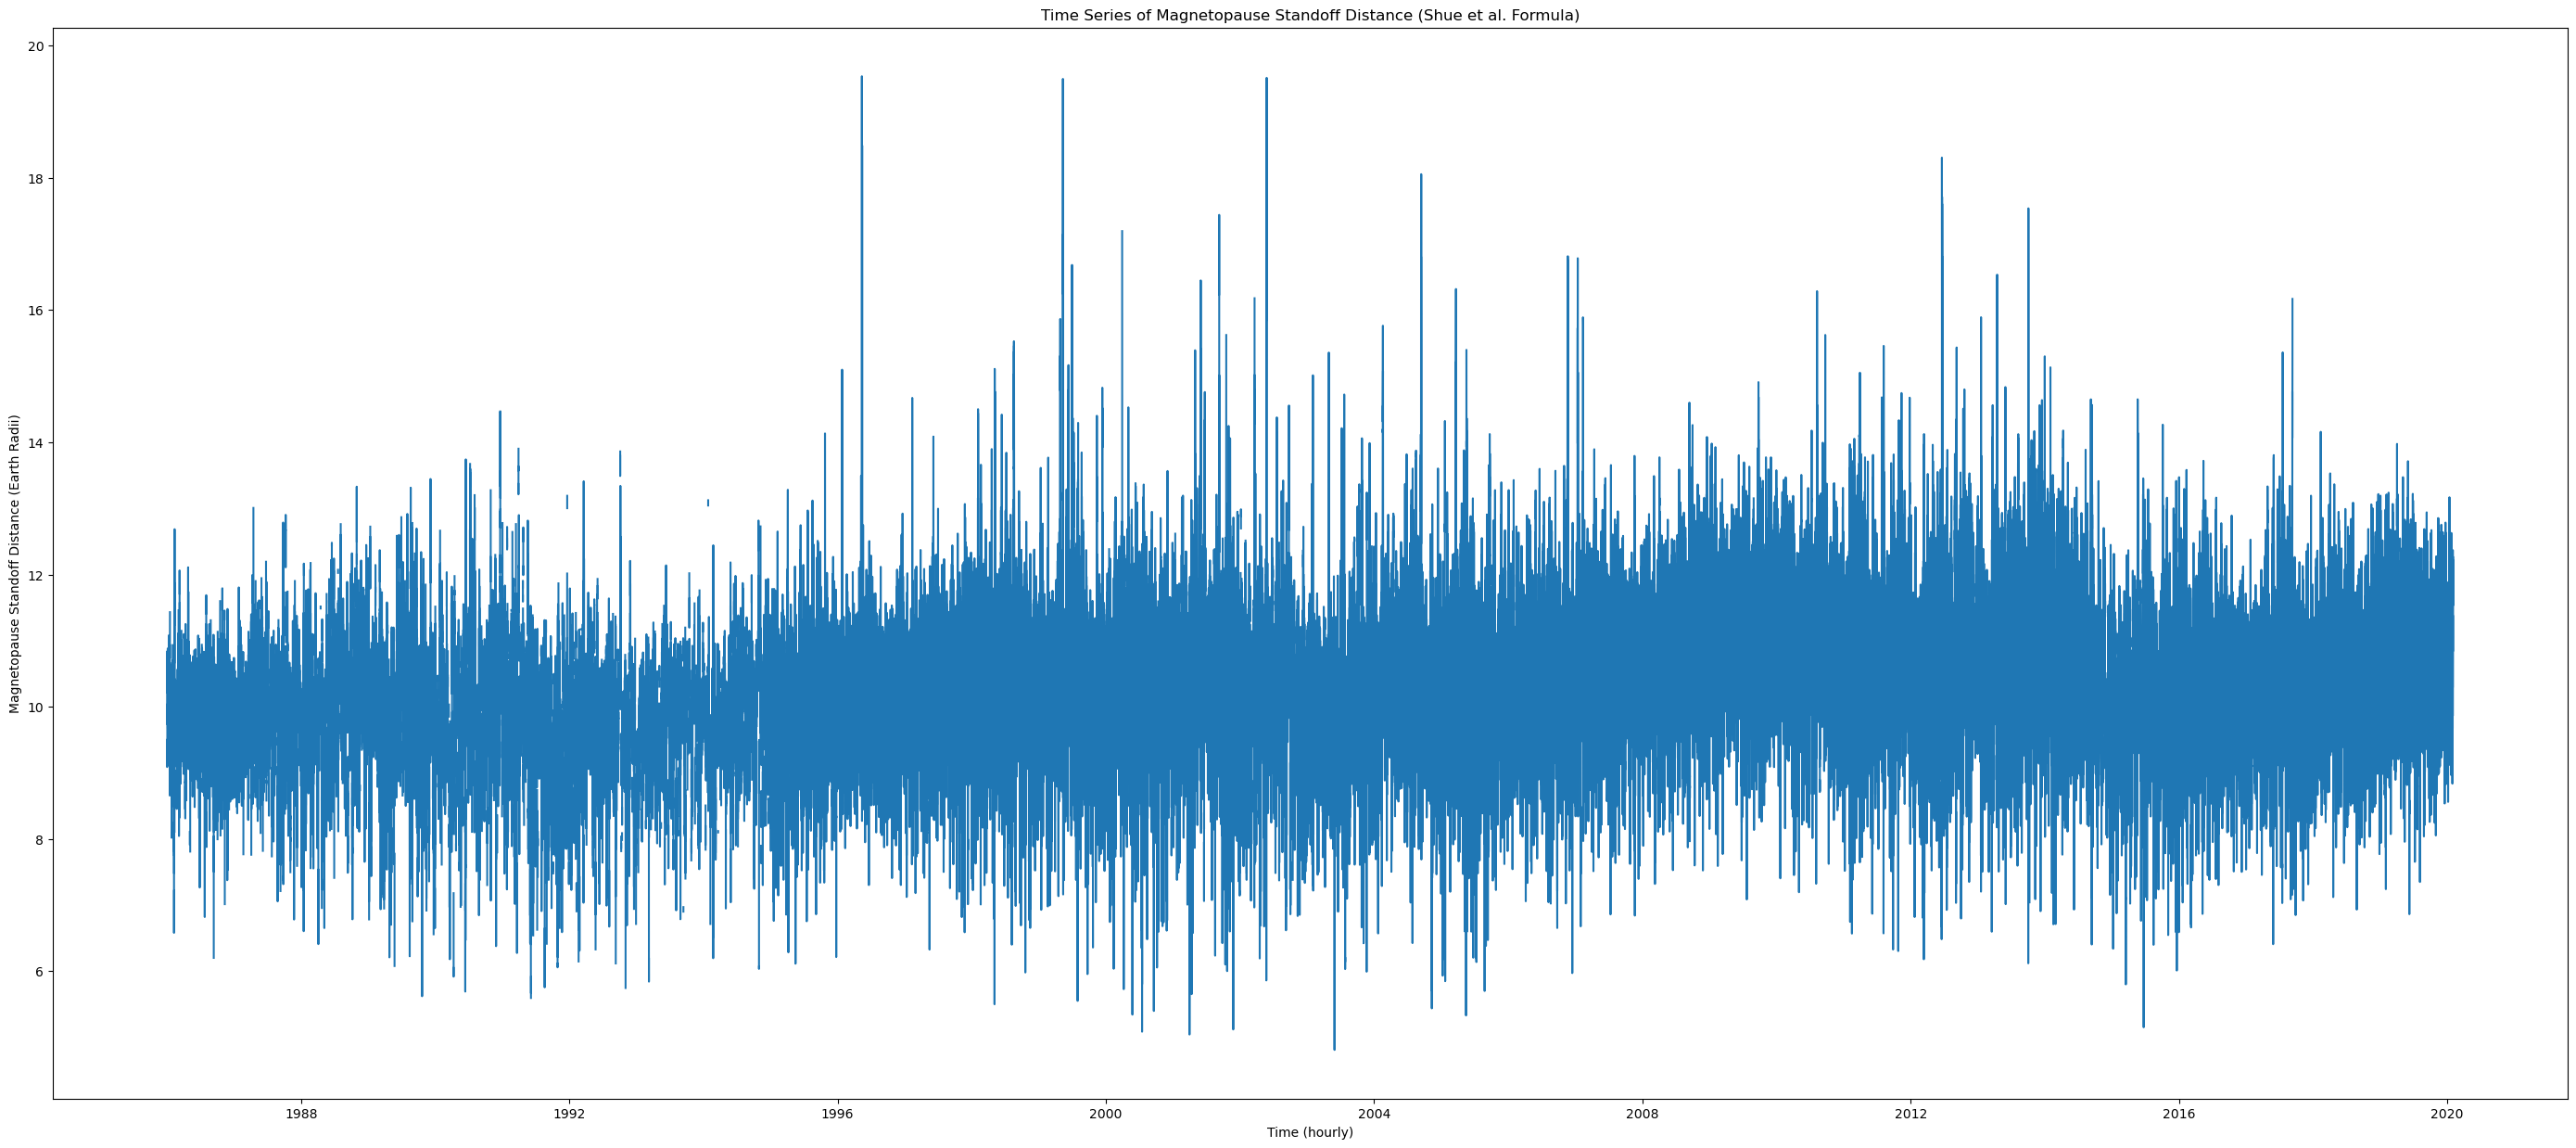

In [80]:
fig = plt.figure(figsize=(35, 15))

plt.plot(data['Date'], magpause_dist_mask, linewidth = 1.5 )
plt.title("Time Series of Magnetopause Standoff Distance (Shue et al. Formula)")
plt.xlabel("Time (hourly)")
plt.ylabel("Magnetopause Standoff Distance (Earth Radii)")




Text(0, 0.5, 'Sunspots Count')

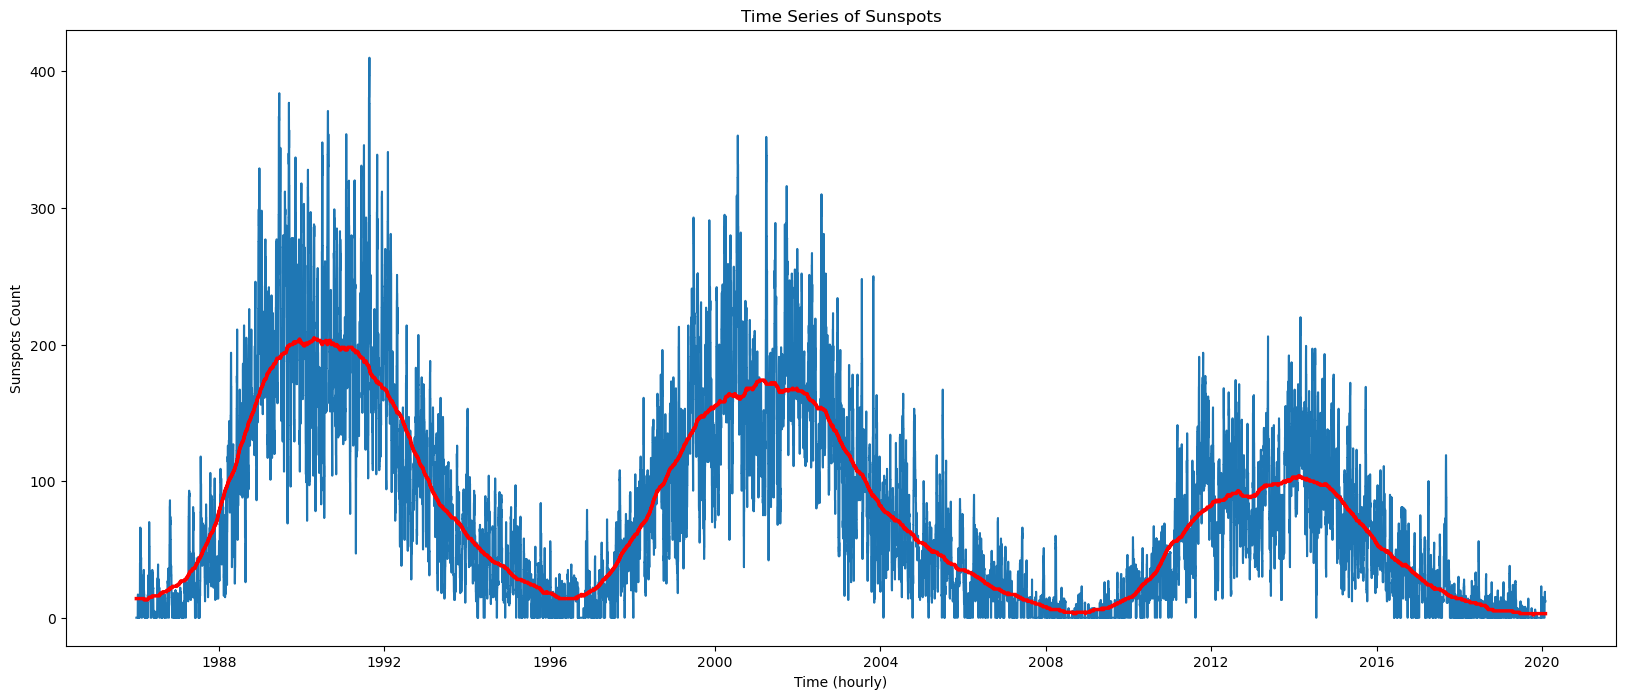

In [81]:
from scipy.ndimage import uniform_filter1d
three_year_mean = uniform_filter1d(data['Sunspots'] , size= 17520)


fig = plt.figure(figsize=(20, 8))

plt.plot(data['Date'], data['Sunspots'], linewidth = 1.5 )
plt.plot(data['Date'], three_year_mean, label='3 Year Running Mean', color = 'red', lw = 2.5)
plt.title("Time Series of Sunspots")
plt.xlabel("Time (hourly)")
plt.ylabel("Sunspots Count")


Frequency associated with max amplitude: 0.029319624066190056
The period associated with the largest amplitutde is 34.106849315068494


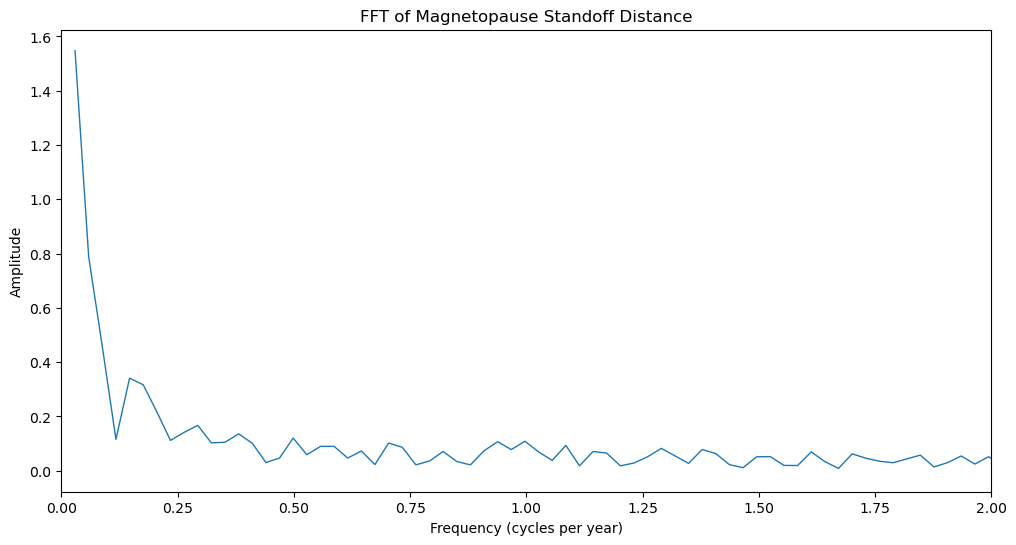

In [82]:
from scipy.fftpack import fft, fftfreq

dt_mag_dist = 1/8760 # Units of fraction of a year
N_mag_dist = len(data) # Length of time series (duration * time step)



magpause_dist_ft = fft(magpause_dist_mask) # Get transform
freqs_mag_dist = fftfreq(N_mag_dist, dt_mag_dist) # Get frequency bins associated with the FT.

positive_freqs_mask = freqs_mag_dist > 0
pos_freqs_mag_dist = freqs_mag_dist[positive_freqs_mask]
pos_data_mag_dist = magpause_dist_ft[positive_freqs_mask]

fig = plt.figure(figsize=(12, 6))
plt.plot(pos_freqs_mag_dist[:N_mag_dist//2], 2.0/N_mag_dist * np.abs(pos_data_mag_dist[:N_mag_dist//2]), '-', lw=1)



plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of Magnetopause Standoff Distance')

plt.xlim(0,2)

max_amplitude_index = np.argmax(np.abs(pos_data_mag_dist[:N_mag_dist//2]))

# Retrieve the corresponding frequency
max_frequency = pos_freqs_mag_dist[max_amplitude_index]
period = 1/max_frequency

print("Frequency associated with max amplitude:", max_frequency)
print(f"The period associated with the largest amplitutde is {period}")


## GEO Crossing 
Next, we will be calculating when the magnetopause is inside Geosynchronous Orbit and studying the frequency.

In [83]:
#Going back to the masked values which are invalid, I am setting all of them to 10 so that it will count as not crossing GEO 
#REFERENCEEE
magpause_dist_filtered = np.ma.filled(magpause_dist_mask, fill_value=10.0) #here I am filling all the masked values to 10

# Create geo_crossing array based on magpause_dist
geo_crossing = np.where(magpause_dist_filtered < 6.6, 1, 0)

# Create a new array with the time column from the data dataset and another column with the geo_crossing values
geo_data = np.column_stack((data['Date'], geo_crossing))

# Initialize a dictionary to store the sum of geo_crossing values for each month of each year
sum_geo_crossing_daily = {}

# Iterate over the rows of geo_data
for row in geo_data:
    # Extract year and month from the date column (assuming it's the first column)
    year_month_day = (row[0].year, row[0].month, row[0].day)
    
    # Get the corresponding geo_crossing value (assuming it's the second column)
    geo = row[1]
    
    # Update the sum for the current day, month, and year
    sum_geo_crossing_daily[year_month_day] = sum_geo_crossing_daily.get(year_month_day, 0) + geo






Text(0, 0.5, 'Hours Inside GEO')

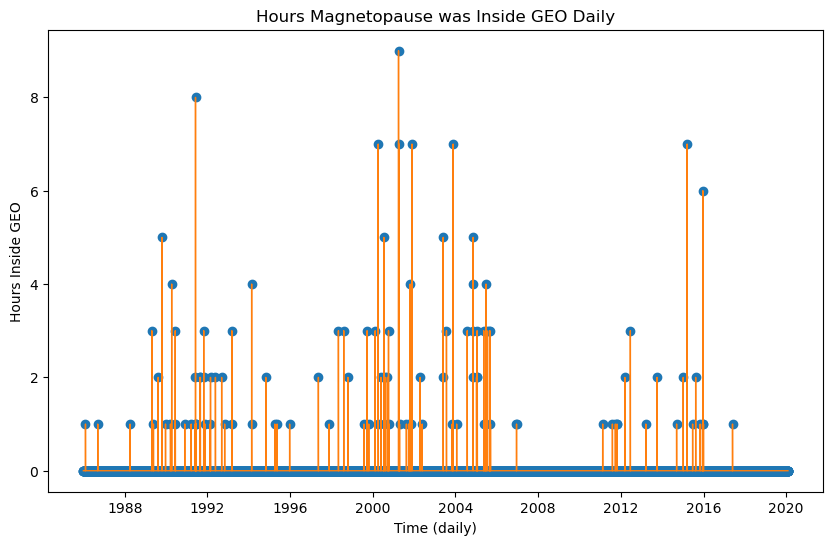

In [86]:
# Extracting dates from sum_geo_crossing_daily keys
dates = [dt.datetime(year, month, day) for year, month, day in sum_geo_crossing_daily.keys()]

# Extracting the daily sums of geo crossings
daily_sums = list(sum_geo_crossing_daily.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_sums, marker='o', linestyle='None')
plt.plot(dates, daily_sums, '-', lw=1)

plt.title('Hours Magnetopause was Inside GEO Daily')
plt.xlabel('Time (daily)')
plt.ylabel('Hours Inside GEO')

Frequency associated with max amplitude: 0.08795887219857017
The period associated with the largest amplitutde is 11.368949771689497


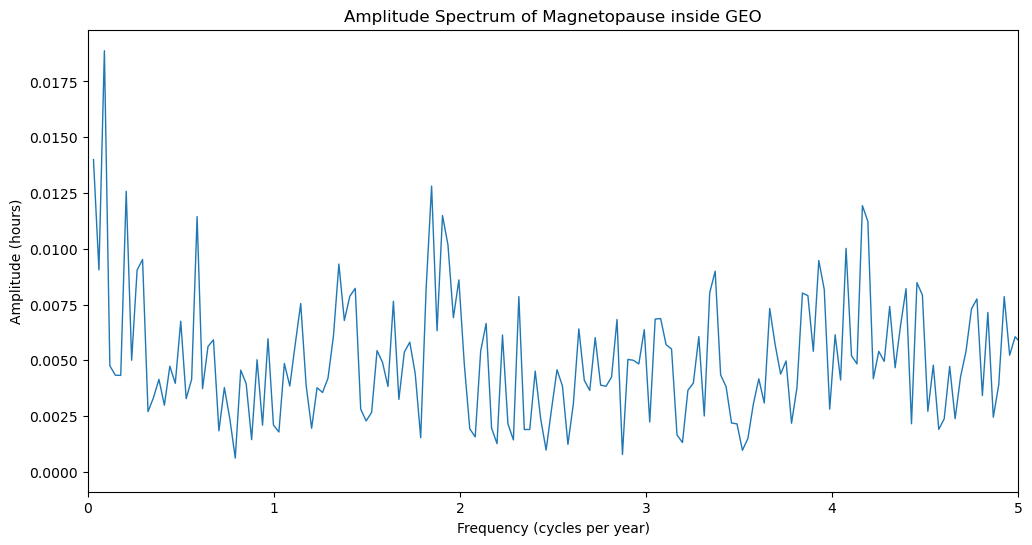

In [69]:
dt = 1/365 # Units of fraction of a year
N = len(dates) # Length of time series (duration * time step)

crossing_daily = np.array(list(sum_geo_crossing_daily.values()))

geo_crossing_ft = fft(crossing_daily) # Get transform
freqs = fftfreq(N, dt) # Get frequency bins associated with the FT.

positive_freqs_mask = freqs > 0
pos_freqs = freqs[positive_freqs_mask]
pos_data = geo_crossing_ft[positive_freqs_mask]

fig = plt.figure(figsize=(12, 6))
plt.plot(pos_freqs[:N//2], 2.0/N * np.abs(pos_data[:N//2]), '-', lw=1)



plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude (hours)')
plt.title('Amplitude Spectrum of Magnetopause inside GEO')

plt.xlim(0,5)

max_amplitude_index = np.argmax(np.abs(pos_data[:N//2]))

# Retrieve the corresponding frequency
max_frequency = pos_freqs[max_amplitude_index]
period = 1/max_frequency

print("Frequency associated with max amplitude:", max_frequency)
print(f"The period associated with the largest amplitutde is {period}")


0.08106727361102577 0.05662677197379573


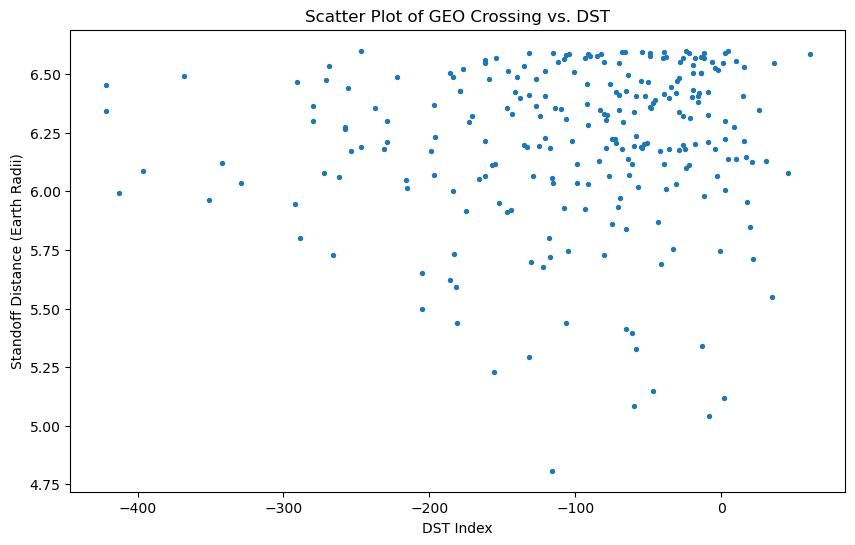

In [39]:
dst_values = data['DST']
geo_crossing_hours = np.where(geo_crossing == 1)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_geo1 = magpause_dist_mask[geo_crossing_hours]
dst_geo1 = dst_values[geo_crossing_hours]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dst_geo1, magpause_dist_geo1, marker='o', s = 8)
plt.title('Scatter Plot of GEO Crossing vs. DST')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('DST Index')

from scipy.stats import kendalltau
kendall_tau, p_value = kendalltau(dst_geo1, magpause_dist_geo1 )

print(kendall_tau, p_value)


0.10846550524254839 6.528693821184666e-88


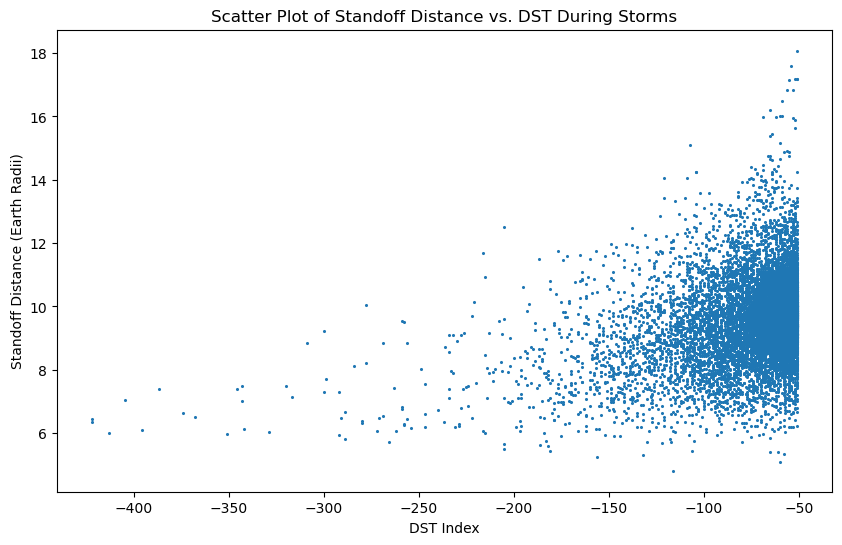

In [38]:
dst_values = data['DST']
storm_times = np.where(data['DST'] < -50)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_storm = magpause_dist_mask[storm_times]
dst_storm = dst_values[storm_times]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dst_storm, magpause_dist_storm, marker='o', s = 1.5)
plt.title('Scatter Plot of Standoff Distance vs. DST During Storms')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('DST Index')


kendall_tau, p_value = kendalltau(dst_storm, magpause_dist_storm)
print(kendall_tau, p_value)